In [1]:
import torch
import torch.nn as nn

# Add the parent directory of 'ml' to sys.path
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from torch.utils.data import DataLoader, TensorDataset
from ml.models.seq2seq_lstm import Seq2SeqLSTM
from ml.utils.data_utils import prepare_dataset
from argparse import Namespace
import numpy as np

In [2]:
# Testing the prepare_dataset function with a sample configuration

args = Namespace(
    data_path='../dataset/full_dataset.csv',
    targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'],
    num_lags=10,
    forecast_steps=6,
    test_size=0.2,
    ignore_cols=None,
    identifier='District',
    nan_constant=0,
    x_scaler='minmax',
    y_scaler='minmax',
    outlier_detection=True
)

X_train, y_train, X_test, y_test, x_scaler, y_scaler, id_train, id_test = prepare_dataset(args)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Train targets shape: {y_train.shape}, Test targets shape: {y_test.shape}")
print(f"Train IDs shape: {id_train.shape}, Test IDs shape: {id_test.shape}")


Train shape: (21596, 10, 6), Test shape: (5399, 10, 6)
Train targets shape: (21596, 6, 5), Test targets shape: (5399, 6, 5)
Train IDs shape: (21596,), Test IDs shape: (5399,)


## Process data

In [10]:
# ─────────────────────────────────────────────────────────────
# STEP 1: Configurations
args = Namespace(
    data_path='../dataset/full_dataset.csv',
    targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'],
    num_lags=10,
    forecast_steps=6,
    test_size=0.2,
    ignore_cols=None,
    nan_constant=0,
    x_scaler='minmax',
    y_scaler='minmax',
    outlier_detection=True,
    identifier='District',   # ✅ ADD THIS LINE
    batch_size=128,
    lr=0.001,
    epochs=20,
    cuda=True,
    seed=42
)

In [11]:
# ─────────────────────────────────────────────────────────────
# STEP 2: Set seed and device
torch.manual_seed(args.seed)
device = torch.device("cuda" if args.cuda and torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [15]:
# ─────────────────────────────────────────────────────────────
# STEP 3: Load and prepare data
X_train, y_train, X_test, y_test, x_scaler, y_scaler, id_train, id_test = prepare_dataset(args)

# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=args.batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=args.batch_size, shuffle=False)

## Model Train

In [18]:
# ─────────────────────────────────────────────────────────────
# STEP 4: Model initialization
input_dim = X_train.shape[2]
output_dim = y_train.shape[2]
model = Seq2SeqLSTM(input_size=input_dim,
                    hidden_size=64,
                    output_size=output_dim,
                    forecast_steps=args.forecast_steps,
                    num_layers=1).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

In [19]:
# ─────────────────────────────────────────────────────────────
# STEP 5: Training Loop
for epoch in range(args.epochs):
    model.train()
    total_loss = 0.0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb, teacher_forcing_ratio=0.5, decoder_targets=yb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{args.epochs} - Train Loss: {avg_loss:.4f}")

Epoch 1/20 - Train Loss: 0.0202
Epoch 2/20 - Train Loss: 0.0110
Epoch 3/20 - Train Loss: 0.0100
Epoch 4/20 - Train Loss: 0.0099
Epoch 5/20 - Train Loss: 0.0093
Epoch 6/20 - Train Loss: 0.0090
Epoch 7/20 - Train Loss: 0.0081
Epoch 8/20 - Train Loss: 0.0081
Epoch 9/20 - Train Loss: 0.0078
Epoch 10/20 - Train Loss: 0.0079
Epoch 11/20 - Train Loss: 0.0076
Epoch 12/20 - Train Loss: 0.0076
Epoch 13/20 - Train Loss: 0.0074
Epoch 14/20 - Train Loss: 0.0076
Epoch 15/20 - Train Loss: 0.0075
Epoch 16/20 - Train Loss: 0.0075
Epoch 17/20 - Train Loss: 0.0072
Epoch 18/20 - Train Loss: 0.0074
Epoch 19/20 - Train Loss: 0.0073
Epoch 20/20 - Train Loss: 0.0073


In [20]:
# ─────────────────────────────────────────────────────────────
# STEP 6: Save model
torch.save(model.state_dict(), "seq2seq_lstm_multistep.pth")
print("✅ Model saved as seq2seq_lstm_multistep.pth")

✅ Model saved as seq2seq_lstm_multistep.pth


## Evaluation

In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace as Namespace
from sklearn.metrics import mean_squared_error, mean_absolute_error

from ml.utils.data_utils import prepare_dataset
from ml.models.seq2seq_lstm import Seq2SeqLSTM

In [23]:
# ─────────────────────────────────────────────────────────────
# STEP 1: Setup arguments
args = Namespace(
    data_path='../dataset/full_dataset.csv',
    targets=['rnti_count', 'rb_down', 'rb_up', 'down', 'up'],
    num_lags=10,
    forecast_steps=6,
    test_size=0.2,
    ignore_cols=None,
    nan_constant=0,
    x_scaler='minmax',
    y_scaler='minmax',
    outlier_detection=True,
    identifier='District',
    batch_size=128,
    cuda=True,
    seed=42
)

device = torch.device("cuda" if args.cuda and torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [24]:
# ─────────────────────────────────────────────────────────────
# STEP 2: Load test data
X_train, y_train, X_test, y_test, x_scaler, y_scaler, id_train, id_test = prepare_dataset(args)

X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)

In [25]:
# ─────────────────────────────────────────────────────────────
# STEP 3: Load model
model = Seq2SeqLSTM(input_size=X_test.shape[2],
                    hidden_size=64,
                    output_size=y_test.shape[2],
                    forecast_steps=args.forecast_steps,
                    num_layers=1).to(device)

model.load_state_dict(torch.load("seq2seq_lstm_multistep.pth", map_location=device))
model.eval()

Seq2SeqLSTM(
  (encoder): LSTM(6, 64, batch_first=True)
  (decoder): LSTM(5, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=5, bias=True)
)

In [26]:
# ─────────────────────────────────────────────────────────────
# STEP 4: Inference
with torch.no_grad():
    preds = model(X_test_t, teacher_forcing_ratio=0)  # shape: [N, 6, 5]

preds = preds.cpu().numpy()
y_test = y_test  # still numpy

In [28]:
# ─────────────────────────────────────────────────────────────
# STEP 5: Evaluation Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate(pred, actual, name):
    rmse = mean_squared_error(actual, pred, squared=False)
    mae = mean_absolute_error(actual, pred)
    print(f"{name}: RMSE = {rmse:.4f}, MAE = {mae:.4f}")

print("\n📊 Evaluation Metrics for All 5 Targets:")
for var in args.targets:
    idx = args.targets.index(var)
    pred_values = preds[:, :, idx].flatten()
    true_values = y_test[:, :, idx].flatten()
    evaluate(pred_values, true_values, var)


📊 Evaluation Metrics for All 5 Targets:
rnti_count: RMSE = 0.0869, MAE = 0.0636
rb_down: RMSE = 0.1058, MAE = 0.0525
rb_up: RMSE = 0.1309, MAE = 0.0576
down: RMSE = 0.0955, MAE = 0.0562
up: RMSE = 0.1213, MAE = 0.0536


c:\Users\Amir\anaconda3\envs\ua\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Amir\anaconda3\envs\ua\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Amir\anaconda3\envs\ua\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Amir\anaconda3\envs\ua\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root 

## Visualization

In [29]:
# ─────────────────────────────────────────────────────────────
# STEP 6: Visualizations

def plot_all_steps(preds, y_test, var_name):
    idx = args.targets.index(var_name)
    fig, axs = plt.subplots(6, 1, figsize=(8, 12), sharex=True)
    for t in range(6):
        axs[t].plot(preds[:, t, idx], label='Predicted', linestyle='--')
        axs[t].plot(y_test[:, t, idx], label='Actual', alpha=0.7)
        axs[t].set_title(f"{var_name} — t+{t+1}")
        axs[t].legend()
    plt.tight_layout()
    plt.show()

def plot_sample_steps(preds, y_test, sample_idx, var_name):
    idx = args.targets.index(var_name)
    plt.plot(range(1, 7), y_test[sample_idx, :, idx], label="Actual", marker='o')
    plt.plot(range(1, 7), preds[sample_idx, :, idx], label="Predicted", marker='x')
    plt.title(f"{var_name} — Forecast for sample {sample_idx}")
    plt.xlabel("t+")
    plt.ylabel("Scaled value")
    plt.xticks(range(1, 7))
    plt.grid(True)
    plt.legend()
    plt.show()


📈 Forecast plots for rb_down


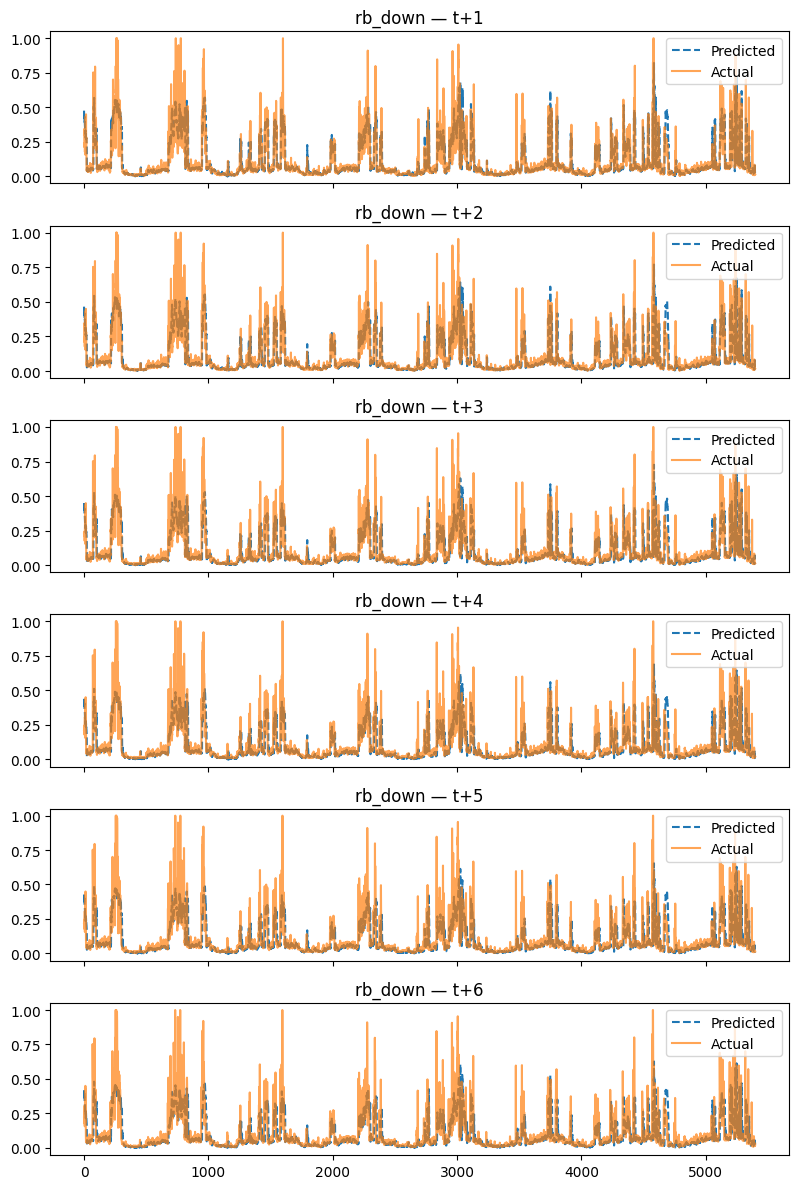

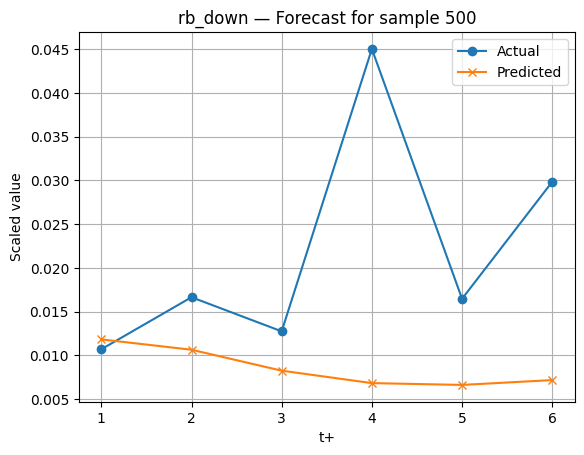


📈 Forecast plots for down


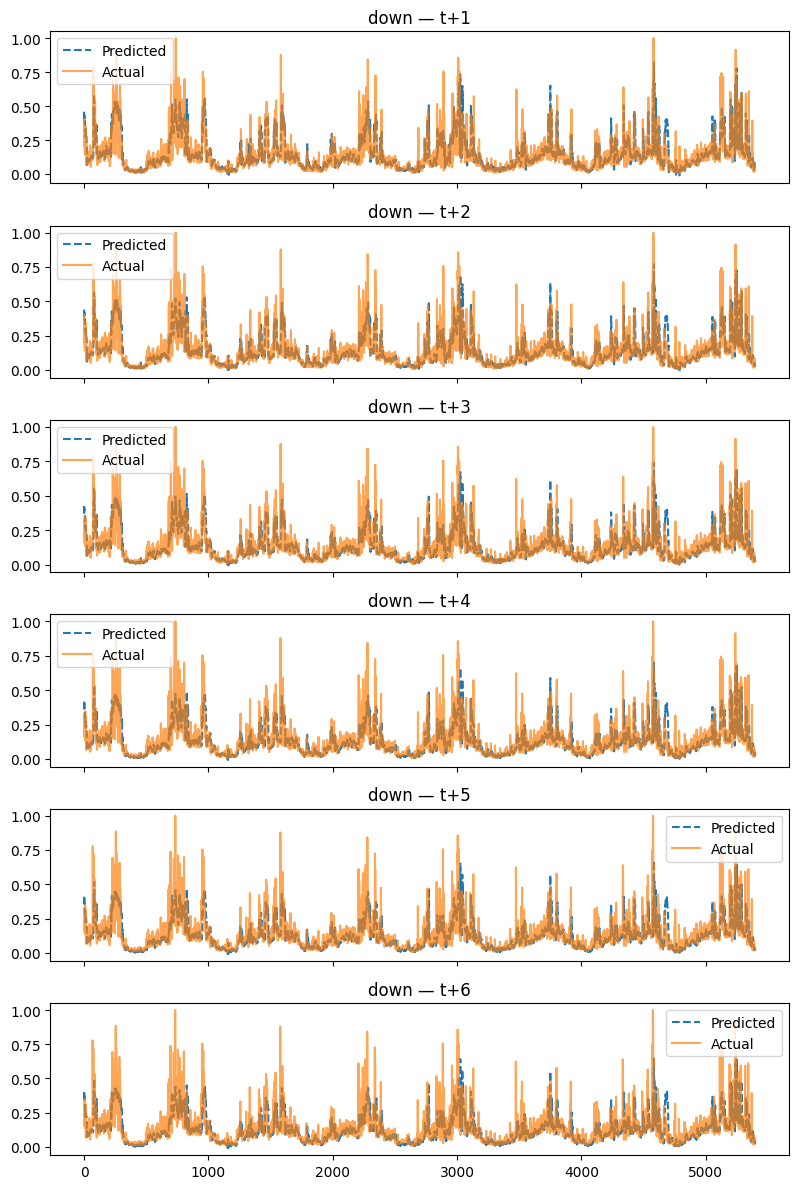

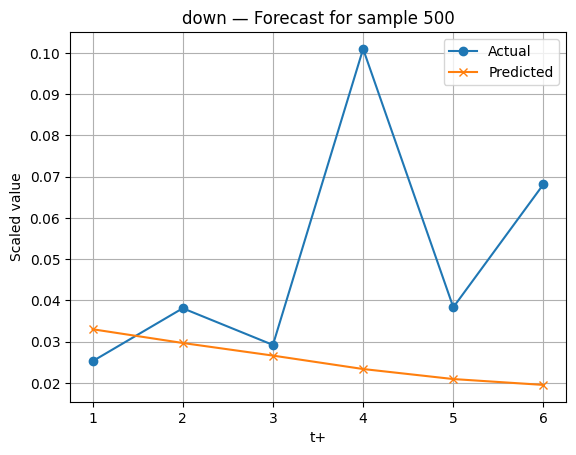

In [30]:
# ───────────── Plot both variables ─────────────
for var in ['rb_down', 'down']:
    print(f"\n📈 Forecast plots for {var}")
    plot_all_steps(preds, y_test, var)
    plot_sample_steps(preds, y_test, sample_idx=500, var_name=var)